In [1]:
import heapq
import numpy as np
import scipy.sparse
from sklearn import linear_model
import sys
import os
from sklearn import preprocessing
import pandas as pd
from copy import deepcopy
from sklearn.metrics import mean_squared_error

from utils_mondrian import sample_cut, errors_regression

In [2]:
def train(X, y, M, lifetime_max, delta,
          mondrian_kernel=False, mondrian_forest=False, weights_from_lifetime=None):
    """
    Sweeps through Mondrian kernels with all lifetime in [0, lifetime_max]. This can be used to (1) construct a Mondrian
    feature map with lifetime lifetime_max, to (2) find a suitable lifetime (inverse kernel width), or to (3) compare
    Mondrian kernel to Mondrian forest across lifetimes.
    :param X:                       training inputs
    :param y:                       training regression targets
    :param M:                       number of Mondrian trees
    :param lifetime_max:            terminal lifetime
    :param delta:                   ridge regression regularization hyperparameter
    :param mondrian_kernel:         flag indicating whether mondrian kernel should be evaluated
    :param mondrian_forest:         flag indicating whether mondrian forest should be evaluated
    :param weights_from_lifetime:   lifetime at which forest and kernel learned weights should be saved
    :return: dictionary res containing all results
    """
    
    N, D = np.shape(X)
    history = []

    if mondrian_forest or mondrian_kernel:
        y = np.squeeze(y)

        # subtract target means
        y_mean = np.mean(y)
        y_train = y - y_mean

    # initialize sparse feature matrix
    indptr = range(0, M * N + 1, M)
    indices = list(range(M)) * N
    data = np.ones(N * M) / np.sqrt(M)
    Z_all = scipy.sparse.csr_matrix((data, indices, indptr), shape=(N, M))
    feature_from_repetition = list(range(M))
    C = M
    X_bd_all = np.tile(X, (M*D,1)).reshape(M,D,N,D)

    # bounding box for all datapoints used to sample first cut in each tree
    feature_data = [np.array(range(N)) for _ in range(M)]
    lX = np.min(X, 0)
    uX = np.max(X, 0)

    # event = tuple (time, tree, feature, dim, loc), where feature is the index of feature being split
    events = []
    active_features = []
    active_features_in_tree = [[] for _ in range(M)]
    for m in range(M):
        cut_time, dim, loc = sample_cut(lX, uX, 0.0)
        if cut_time < lifetime_max:
            heapq.heappush(events, (cut_time, m, m, dim, loc))
        active_features.append(m)
        active_features_in_tree[m].append(m)

    # iterate through birth times in increasing order
    if mondrian_forest:
        w_trees = [np.zeros(1) for _ in range(M)]
        trees_y_hat_train = np.zeros((N, M))        # initialize Mondrian tree predictions and squared errors
    if mondrian_kernel:
        w_kernel = np.zeros(M)

    while len(events) > 0:
        (birth_time, m, c, dim, loc) = heapq.heappop(events)
        history.append((birth_time, m, c, dim, loc))

        # construct new feature
        Xd = X[feature_data[c], dim]
        feature_l = (feature_data[c])[Xd <= loc]
        feature_r = (feature_data[c])[Xd  > loc]
        feature_data.append(feature_l)
        feature_data.append(feature_r)

        active_features.remove(c)
        active_features_in_tree[m].remove(c)
        active_features.append(C + 0)
        active_features.append(C + 1)
        active_features_in_tree[m].append(C + 0)
        active_features_in_tree[m].append(C + 1)

        # move datapoints from split feature to child features
        Z_all.indices[feature_l * M + m] = C + 0
        Z_all.indices[feature_r * M + m] = C + 1
        Z_all = scipy.sparse.csr_matrix((Z_all.data, Z_all.indices, Z_all.indptr), shape=(N, C + 2), copy=False)

        # sample the cut for each child
        lX_l = np.min(X[feature_l, :], axis=0)
        uX_l = np.max(X[feature_l, :], axis=0)
        cut_time_l, dim_l, loc_l = sample_cut(lX_l, uX_l, birth_time)
        lX_r = np.min(X[feature_r, :], axis=0)
        uX_r = np.max(X[feature_r, :], axis=0)
        cut_time_r, dim_r, loc_r = sample_cut(lX_r, uX_r, birth_time)

        if (loc_l is not None) and (loc_r is not None):
            X_bd_all[m, dim, feature_l, dim] = lX_r[dim]
            X_bd_all[m, dim, feature_r, dim] = uX_l[dim]

        # add new cuts to heap
        if cut_time_l < lifetime_max:
            heapq.heappush(events, (cut_time_l, m, C + 0, dim_l, loc_l))
        if cut_time_r < lifetime_max:
            heapq.heappush(events, (cut_time_r, m, C + 1, dim_r, loc_r))

        feature_from_repetition.append(m)
        feature_from_repetition.append(m)
        C += 2

        if mondrian_forest:
            # update Mondrian forest predictions in tree m
            Z_train = Z_all[:N, active_features_in_tree[m]]
            w_tree = np.linalg.solve(np.transpose(Z_train).dot(Z_train) + delta / M * np.identity(len(active_features_in_tree[m])),
                                np.transpose(Z_train).dot(y_train))
            if weights_from_lifetime is not None and birth_time <= weights_from_lifetime:
                w_trees[m] = w_tree / np.sqrt(M)
            trees_y_hat_train[:, m] = np.squeeze(Z_train.dot(w_tree))

        # update Mondrian kernel predictions
        if mondrian_kernel:
            w_kernel = np.append(w_kernel, [w_kernel[c], w_kernel[c]])
            w_kernel[c] = 0

            clf = linear_model.SGDRegressor(alpha=delta, fit_intercept=False)
            clf.fit(Z_all, y_train, coef_init=w_kernel)
            w_kernel = clf.coef_

    # this function returns a dictionary with all values of interest stored in it
    
    results = {'Z': Z_all, 'feature_from_repetition': np.array(feature_from_repetition)}
    if mondrian_kernel:
        y_hat_train = y_mean + Z_all.dot(w_kernel)
    return results, X_bd_all, X, history, w_kernel, y_hat_train

def evaluate(X, y, X_test, M, delta, history, w_kernel,
             mondrian_kernel=False, mondrian_forest=False, weights_from_lifetime=None,):
    """
    Sweeps through Mondrian kernels with all lifetime in [0, lifetime_max]. This can be used to (1) construct a Mondrian
    feature map with lifetime lifetime_max, to (2) find a suitable lifetime (inverse kernel width), or to (3) compare
    Mondrian kernel to Mondrian forest across lifetimes.
    :param X:                       training inputs
    :param y:                       training regression targets
    :param X_test:                  test inputs
    :param y_test:                  test regression targets
    :param M:                       number of Mondrian trees
    :param lifetime_max:            terminal lifetime
    :param delta:                   ridge regression regularization hyperparameter
    :param validation:              flag indicating whether a validation set should be created by halving the test set
    :param mondrian_kernel:         flag indicating whether mondrian kernel should be evaluated
    :param mondrian_forest:         flag indicating whether mondrian forest should be evaluated
    :param weights_from_lifetime:   lifetime at which forest and kernel learned weights should be saved
    :return: dictionary res containing all results
    """
    N, D = np.shape(X)
    N_test = np.shape(X_test)[0]
    X_all = np.array(np.r_[X, X_test])
    N_all = N + N_test
    history = deepcopy(history)

    if mondrian_forest or mondrian_kernel:
        y = np.squeeze(y)

        # subtract target means
        y_mean = np.mean(y)
        y_train = y - y_mean

    # initialize sparse feature matrix
    indptr = range(0, M * N_all + 1, M)
    indices = list(range(M)) * N_all
    data = np.ones(N_all * M) / np.sqrt(M)
    Z_all = scipy.sparse.csr_matrix((data, indices, indptr), shape=(N_all, M))
    C = M

    # iterate through birth times in increasing order
    if mondrian_forest:
        w_trees = [np.zeros(1) for _ in range(M)]
        trees_y_hat_train = np.zeros((N, M))        # initialize Mondrian tree predictions and squared errors
        trees_y_hat_test = np.zeros((N_test, M))
    
    feature_data = [np.array(range(N_all)) for _ in range(M)]
    active_features = []
    active_features_in_tree = [[] for _ in range(M)]
    for m in range(M):
        active_features.append(m)
        active_features_in_tree[m].append(m)

    while len(history) > 0:
        (birth_time, m, c, dim, loc) = history.pop(0)

        # construct new feature
        Xd = X_all[feature_data[c], dim]
        feature_l = (feature_data[c])[Xd <= loc]
        feature_r = (feature_data[c])[Xd  > loc]
        feature_data.append(feature_l)
        feature_data.append(feature_r)

        active_features.remove(c)
        active_features_in_tree[m].remove(c)
        active_features.append(C + 0)
        active_features.append(C + 1)
        active_features_in_tree[m].append(C + 0)
        active_features_in_tree[m].append(C + 1)

        # move datapoints from split feature to child features
        Z_all.indices[feature_l * M + m] = C + 0
        Z_all.indices[feature_r * M + m] = C + 1
        Z_all = scipy.sparse.csr_matrix((Z_all.data, Z_all.indices, Z_all.indptr), shape=(N_all, C + 2), copy=False)

        C += 2

        if mondrian_forest:
            # update Mondrian forest predictions in tree m
            Z_train = Z_all[:N, active_features_in_tree[m]]
            Z_test = Z_all[N:, active_features_in_tree[m]]
            w_tree = np.linalg.solve(np.transpose(Z_train).dot(Z_train) + delta / M * np.identity(len(active_features_in_tree[m])),
                                np.transpose(Z_train).dot(y_train))
            if weights_from_lifetime is not None and birth_time <= weights_from_lifetime:
                w_trees[m] = w_tree / np.sqrt(M)
            trees_y_hat_train[:, m] = np.squeeze(Z_train.dot(w_tree))
            trees_y_hat_test[:, m] = np.squeeze(Z_test.dot(w_tree))

            # update Mondrian forest error
            y_hat_train = y_mean + np.mean(trees_y_hat_train, 1)
            y_hat_test = y_mean + np.mean(trees_y_hat_test, 1)

        # update Mondrian kernel predictions
    
    if mondrian_kernel:
        Z_train = Z_all[:N]
        Z_test = Z_all[N:]
        y_hat_train = y_mean + Z_train.dot(w_kernel)
        y_hat_test = y_mean + Z_test.dot(w_kernel)
    return y_hat_train, y_hat_test
    
def simulate_y(x, seed = 0, noise_sig2 = 0.0001):
    y = x[:, 0]**4 + x[:, 1]**4 + x[:, 2]**4 + x[:, 3]**4 + x[:, 4]**4
    r_noise = np.random.RandomState(seed)
    n = len(x)
    noise = r_noise.randn(n, 1) * np.sqrt(noise_sig2)
    y = y + noise[:, 0]
    return y

import matplotlib.pyplot as plt
def draw(dim_in, psi_est, labels = None):
    x = np.linspace(0, dim_in-1, dim_in)
    fig, ax = plt.subplots()

    ax.plot(x, psi_est, linewidth=1.0, label = "diag")
    if labels is not None:
        plt.xticks(x, labels)
    plt.legend()
    plt.show()

In [3]:
def populate_importance(subset_vector, importance):
    importance = list(importance)
    m = len(subset_vector)
    res = np.zeros(m)
    for i in range(m):
        if subset_vector[i] != 0:
            res[i] = importance.pop()
    return res

n = 5000
dim_in = 25
x_train = np.random.rand(n,dim_in)*2 - 1
y_train = simulate_y(x_train)

x_test = np.random.rand(n,dim_in)*2 - 1
y_test = simulate_y(x_test)

M = 100                      # number of Mondrian trees to use
lifetime_max = 0.1          # terminal lifetime
weights_lifetime = 2*1e-6   # lifetime for which weights should be plotted
delta = 0.1              # ridge regression delta
result, X_bd_all, X, history, w_kernel, y_hat_train = train(x_train, y_train, M, lifetime_max, delta, mondrian_kernel = True,
                            weights_from_lifetime=weights_lifetime)

mean_squared_error(y_train, y_hat_train)


0.35576694515627066

In [4]:
importance = []
for dim in range(dim_in):
    x_eval = None
    y_eval = []
    x_diff = []
    subset_all = []
    for tree in range(M):
        temp = X_bd_all[tree,dim] - X
        subset = temp[:,dim] != 0
        subset_all = subset_all + list(subset)
        if sum(subset) > 0:
            if x_eval is None:
                x_eval = X_bd_all[tree,dim][subset]
            else:
                x_eval = np.vstack((x_eval, X_bd_all[tree,dim][subset]))
            y_eval = y_eval + list(y_hat_train[subset])
            x_diff = x_diff + list(temp[:,dim][subset])

    _, y_hat_eval = evaluate(x_train, y_train, x_eval, M, delta, history, w_kernel, mondrian_kernel = True, 
                            weights_from_lifetime=weights_lifetime)
    
    importance_temp = populate_importance(subset_all, ((y_eval - y_hat_eval)/x_diff))
    importance_temp = np.reshape(importance_temp, (len(X), M))
    importance_temp = np.mean(importance_temp, axis = 1)
    importance.append(importance_temp)
importance = np.vstack(importance)

_, y_hat_test = evaluate(x_train, y_train, x_test, M, delta, history, w_kernel, mondrian_kernel = True, 
                            weights_from_lifetime=weights_lifetime)


mean_squared_error(y_test, y_hat_test)

0.3493195293749408

In [5]:
H = np.matmul(importance, np.transpose(importance))

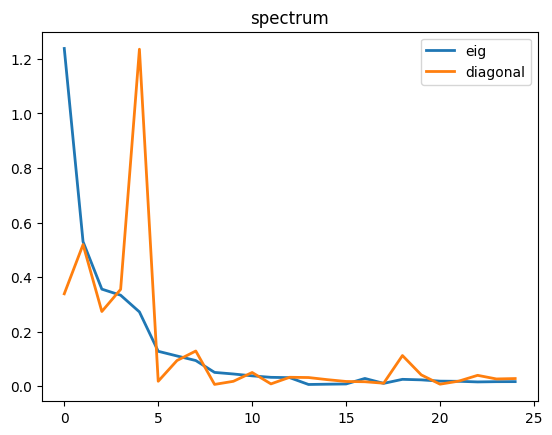

In [6]:
def plot_spectrum(y, y_diag, title):
    x = np.linspace(0, len(y)-1, len(y))

    fig, ax = plt.subplots()

    ax.plot(x, y, linewidth=2.0, label = "eig")
    ax.plot(x, y_diag, linewidth=2.0, label = "diagonal")

    plt.legend()
    plt.title(title)
    plt.show()

eig = np.linalg.eig(H)[0]
y_diag = np.diagonal(H)
plot_spectrum(eig, y_diag, 'spectrum')

In [24]:
x_train_transformed = np.matmul(x_train, H)
x_test_transformed = np.matmul(x_test, H)
result, X_bd_all, X, history, w_kernel, y_hat_train = train(x_train_transformed, y_train, M, lifetime_max, delta, mondrian_kernel = True,
                            weights_from_lifetime=weights_lifetime)

mean_squared_error(y_train, y_hat_train)

0.3496186110938849

In [25]:
_, y_hat_test = evaluate(x_train_transformed, y_train, x_test_transformed, M, delta, history, w_kernel, mondrian_kernel = True, 
                            weights_from_lifetime=weights_lifetime)

mean_squared_error(y_test, y_hat_test)

0.3420238636897114